In [1]:
# -*- coding: utf-8 -*- 
# This code is written in Python 3.7. To install the required packages, run the following commands:
# pip install pandas numpy matplotlib seaborn scikit-learn sympy
# This code is applicable to the N_BaIoT dataset. 
# implemented a MplClassifier using a simple neural network. 

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
import time 
import numpy as np

2024-05-27 22:21:32.676373: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-27 22:21:32.714634: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 22:21:33.412397: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

df = pd.read_csv('/home/ibibers@ads.iu.edu/IOT_Datasets/device7.csv')

# Drop duplicates
df = df.drop_duplicates(keep='first')

# Drop columns that have just one unique value
one_value = df.columns[df.nunique() == 1]
df = df.drop(columns = one_value, axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115936 entries, 0 to 119999
Columns: 116 entries, MI_dir_L5_weight to label
dtypes: float64(115), int64(1)
memory usage: 103.5 MB


In [3]:

# Extract subsample of data
print (" Extract subsample of data: ")
print(df['label'].value_counts())

 Extract subsample of data: 
label
4    20000
3    20000
6    20000
1    19623
5    18157
2    18156
Name: count, dtype: int64


In [4]:
dropped_df = ['label']
X = df.drop(dropped_df, axis=1)
y = df['label']


In [5]:
start_time = time.time()
# Initial train test split set and split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize MirroredStrategy for GPU acceleration
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # initialization for MLPClassifier
    nn_model = MLPClassifier(
        hidden_layer_sizes=(50, 50),  
        activation='relu',            # Rectified Linear Unit (ReLU)
        solver='adam',                
        alpha=0.0001,                  # L2 regularization term
        batch_size='auto',             # Auto-adjust batch size based on the size of the dataset
        learning_rate='constant',      # Constant learning rate
        learning_rate_init=0.001,      # Initial learning rate
        max_iter=1000,                 # Maximum number of iterations
        random_state=42,               
        early_stopping=False,          # Disable early stopping
        verbose=True                   # Print progress messages during training
    )
    
    # Train 
    start_train_time = time.time()
    nn_model.fit(X_train, y_train)
    train_time = time.time() - start_train_time

    
    # Make predictions 
    start_pred_time = time.time()    
    y_pred_encoded = nn_model.predict(X_test)
    pred_time = time.time() - start_pred_time

total_time = time.time() - start_time

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


2024-05-27 22:21:36.141931: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Iteration 1, loss = 20.91732248
Iteration 2, loss = 19.82249880
Iteration 3, loss = 20.26466827
Iteration 4, loss = 20.56636921
Iteration 5, loss = 20.55145465
Iteration 6, loss = 20.29330474
Iteration 7, loss = 20.40097047
Iteration 8, loss = 20.67649097
Iteration 9, loss = 20.43211974
Iteration 10, loss = 20.40300567
Iteration 11, loss = 20.55932075
Iteration 12, loss = 20.78214240
Iteration 13, loss = 19.92802982
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [6]:
print("Time taken for training:{:f} seconds".format(train_time))
print("Time taken for prediction: {:f} seconds".format(pred_time))
print("Total time taken:{:f} seconds".format(total_time))

Time taken for training:7.242673 seconds
Time taken for prediction: 0.044032 seconds
Total time taken:7.462375 seconds


In [7]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_encoded)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5220091429228602


In [8]:
#  Classificaiton Report 
print("\nClassification Report:")
print(classification_report(y_test, y_pred_encoded))


Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.99      0.67      5887
           2       0.42      1.00      0.59      5447
           3       0.65      0.42      0.51      6000
           4       1.00      0.59      0.74      6000
           5       0.00      0.00      0.00      5447
           6       0.31      0.14      0.19      6000

    accuracy                           0.52     34781
   macro avg       0.48      0.52      0.45     34781
weighted avg       0.49      0.52      0.45     34781



/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

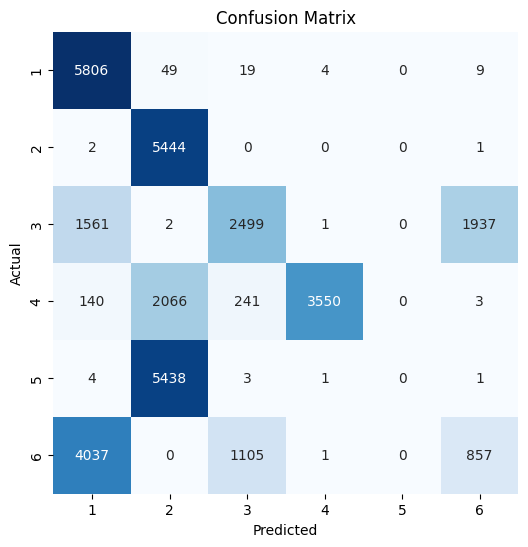

In [9]:
# Confusion matrix with string labels
conf_mat = confusion_matrix(y_test, y_pred_encoded)

# Get unique class labels from y_test and y_pred_encoded
unique_labels = np.unique(np.concatenate((y_test, y_pred_encoded)))

# Plotting the Confusion Matrix with class labels
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/tmp/ipykernel_1161671/2030256363.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(sorted_importance.values()), y=list(


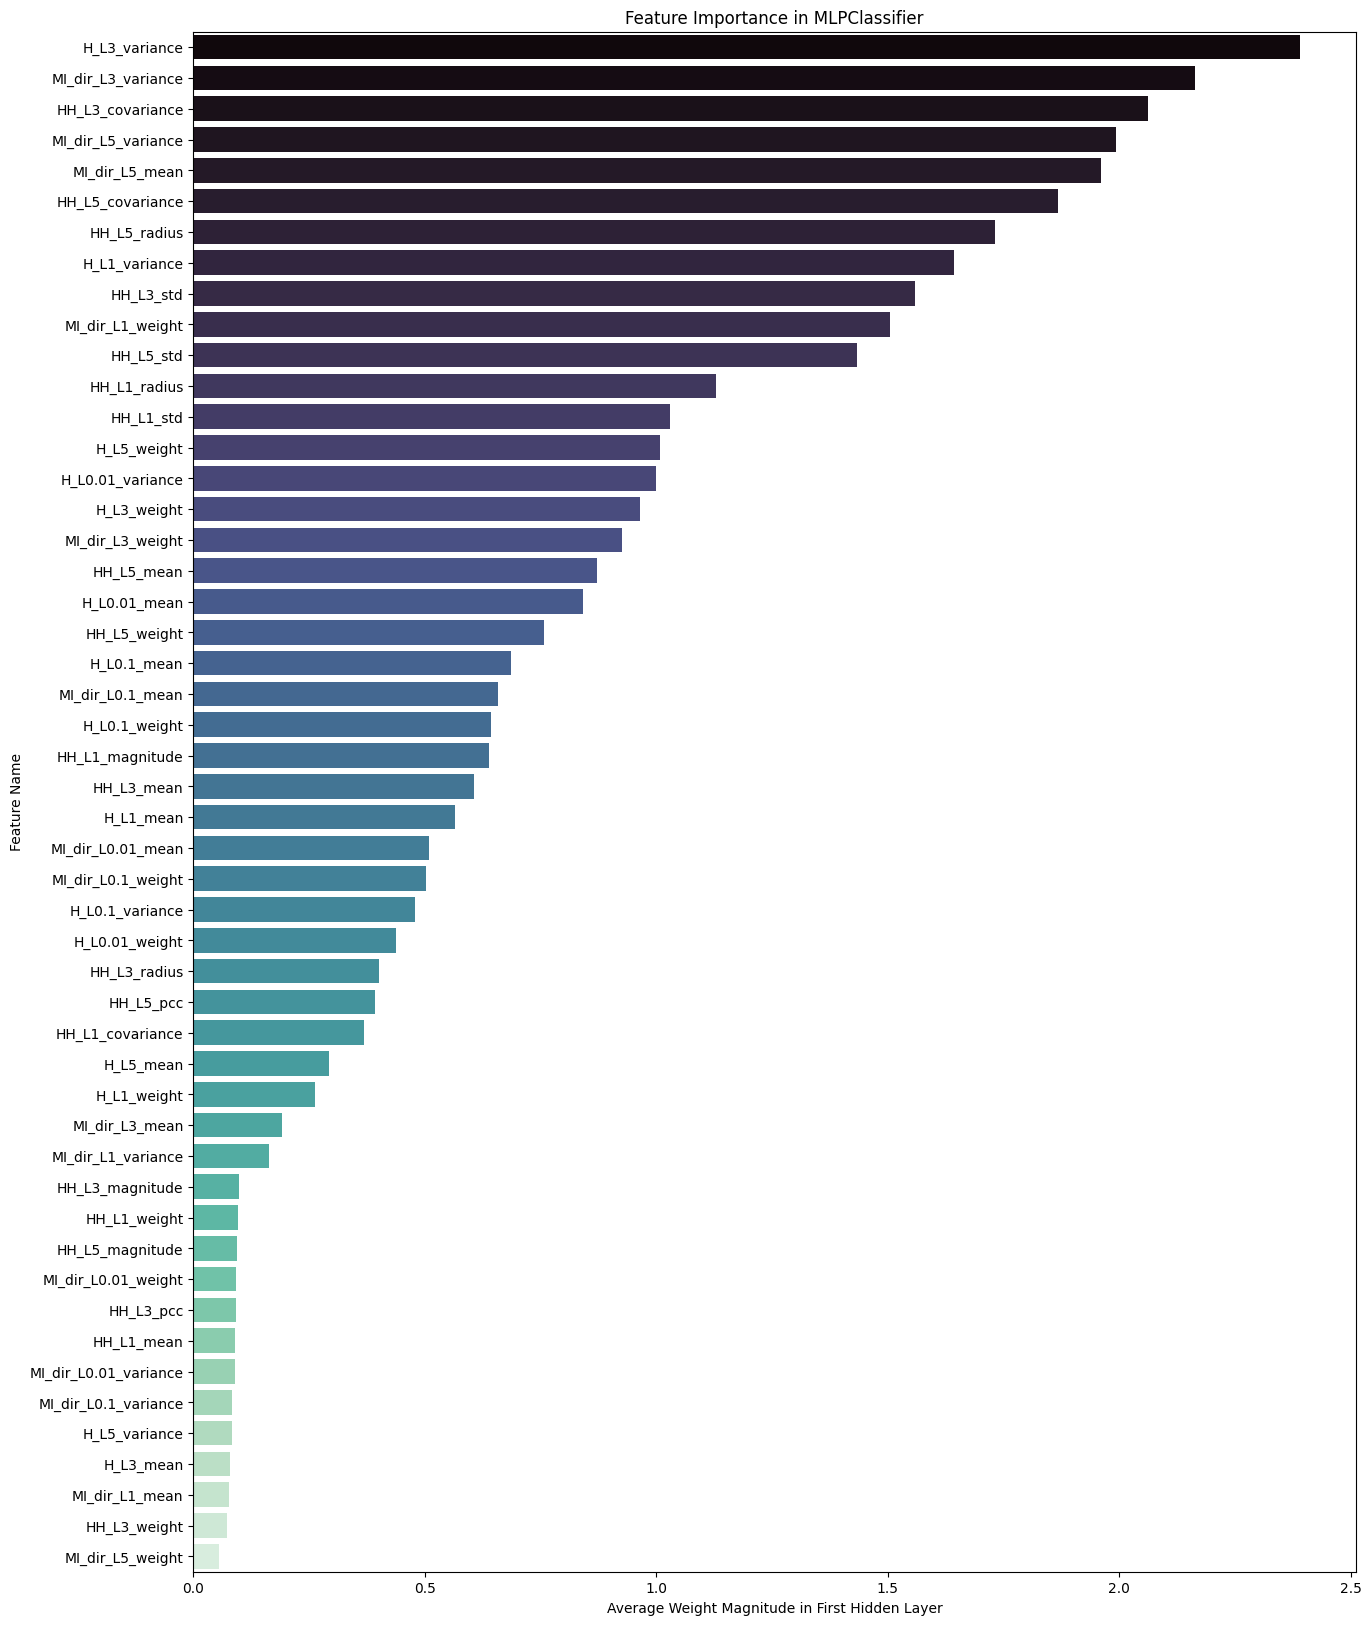

In [15]:
# Extract weights from the first hidden layer
weights_first_hidden_layer = nn_model.coefs_[0]

# Calculate feature importance based on the weights
feature_importance = np.abs(weights_first_hidden_layer).mean(axis=0)

# Create a DataFrame for visualization
importance_dict = dict(zip(X.columns.values, feature_importance))
sorted_importance = dict(
    sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))

# Visualize the feature importance
plt.figure(figsize=(15, 20))
sns.barplot(x=list(sorted_importance.values()), y=list(
    sorted_importance.keys()), palette='mako')
plt.xlabel('Average Weight Magnitude in First Hidden Layer')
plt.ylabel('Feature Name')
plt.title('Feature Importance in MLPClassifier')
plt.show()

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_encoded)
# precision = precision_score(y_test, y_pred_encoded)
# recall = recall_score(y_test, y_pred_encoded)
# f1 = f1_score(y_test, y_pred_encoded)
conf_matrix = confusion_matrix(y_test, y_pred_encoded)

# Print evaluation metrics
print("Prediction Evaluation:")
print("Accuracy:".format(accuracy))
# print("Precision: ".format(precision))
# print("Recall: ".format(recall))
# print("F1-score: ".format(f1))
print("Confusion Matrix:")
print(conf_matrix)


Prediction Evaluation:
Accuracy:
Confusion Matrix:
[[5806   49   19    4    0    9]
 [   2 5444    0    0    0    1]
 [1561    2 2499    1    0 1937]
 [ 140 2066  241 3550    0    3]
 [   4 5438    3    1    0    1]
 [4037    0 1105    1    0  857]]
